# Coding assessment for Clinical Computational Cancer Genomics
## Ian Snyder 

### Motivation: Discover any mutations that are associated with treatment response?

Step 1: import neccessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from getdata import GetData


ModuleNotFoundError: No module named 'getdata'

Load Patient Data, patiendDf is seperated by patient, aggDf is concatenated patient data.

In [ ]:
data = GetData('data/mafs')
patientDf = data.patientDf
aggDf = data.aggDf



Subset for mutations that are not of the Variant Classification “Silent”.

In [ ]:
#subset aggdata
condition = aggDf['Variant_Classification'] != 'Silent'
aggSubset = aggDf[condition]
#Do the same for each patient
subsetDf = {}
for patient, patientDf in patientDf.items():
    condition = patientDf['Variant_Classification'] != 'Silent'
    df_subset = patientDf[condition]
    subsetDf[patient] = df_subset 
#Rassign global var to new subset
patientDf=subsetDf
aggDf = aggSubset

aggDf.head()

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,CEP350,1,180063656,180063656,Missense_Mutation,SNP,G,G,A,Patient-36-Tumor,Patient-36-Normal,p.E2806K,12,28
1,CCDC88C,14,91739009,91739009,Missense_Mutation,SNP,C,C,T,Patient-36-Tumor,Patient-36-Normal,p.G2016E,36,57
2,KDM6B,17,7749509,7749509,Missense_Mutation,SNP,A,A,T,Patient-36-Tumor,Patient-36-Normal,p.Y117F,4,25
3,PGAP1,2,197781268,197781268,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.F117L,11,25
4,PARD6B,20,49366765,49366765,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.E287Q,21,88


Find the 15 most common mutations. Tie handling was not specified so both are provided, intuitivley it makes sense to include ties.

In [ ]:
#Relevant Data
aggDf_small = aggDf[['Hugo_Symbol', 'Protein_Change']].copy()
#Count Mutations
mutation_counts = aggDf_small.groupby(['Hugo_Symbol', 'Protein_Change']
                     ).size().reset_index(name='Count')

mutation_counts.sort_values(by=['Count'], ascending=False, inplace=True)
#Rank based on count
mutation_counts['Rank'] = mutation_counts['Count'].rank(
    method='min', ascending=False)

#Get top 15 ranks
top_mutations = mutation_counts[mutation_counts['Rank'] <= 15]

#With ties 
print(top_mutations)

#Without handling ties
print(mutation_counts.head(15))

      Hugo_Symbol Protein_Change  Count  Rank
2869        ERBB4       p.S1289A     14   1.0
2858        ERBB3        p.H228Q      5   2.0
6897       PIK3CA        p.E545K      5   2.0
2868        ERBB4        p.Q707E      5   2.0
5205       MAP2K1         p.F53L      4   5.0
7961         RXRA        p.S330F      4   5.0
9782        TYRO3        p.L819M      4   5.0
2860        ERBB3         p.M91I      4   5.0
2865        ERBB4        p.E317K      4   5.0
3038       FAM47C        p.Q225E      4   5.0
4835    KRTAP4-11        p.L161V      4   5.0
9479         TP53        p.R248Q      4   5.0
10828       ZNF91        p.H305R      3  13.0
10724      ZNF708        p.L251P      3  13.0
10789      ZNF814        p.D404E      3  13.0
10841       ZNF93        p.R533G      3  13.0
3037       FAM47C        p.N648D      3  13.0
7019       PLXNA2       p.E1480K      3  13.0
9784        TYRO3        p.R824G      3  13.0
10704      ZNF681        p.S505P      3  13.0
10821      ZNF878        p.R200S  

Perform a statistical test to explore if any mutated genes are enriched in patients who
either responded or not.

25
25
Chi-Square statistic: 368.85665453419114
P-value: 1.0
0.7454394693200663
     Hugo_Symbol  Count_responders  Count_non_responders  differences
516        KMT2C                19                     1           18
948         SPEN                 6                    16           10
1065       TYRO3                 1                    10            9
231         CUBN                 8                     1            7
276          DST                 9                     3            6
467         IRS4                 1                     7            6
978        SYNE1                 9                     3            6
611       MYCBP2                 7                     1            6
263        DNAH8                 6                     1            5
530        LAMA3                 6                     1            5
341        FBLN1                 1                     6            5
635       NBPF10                 7                     2            5
517        

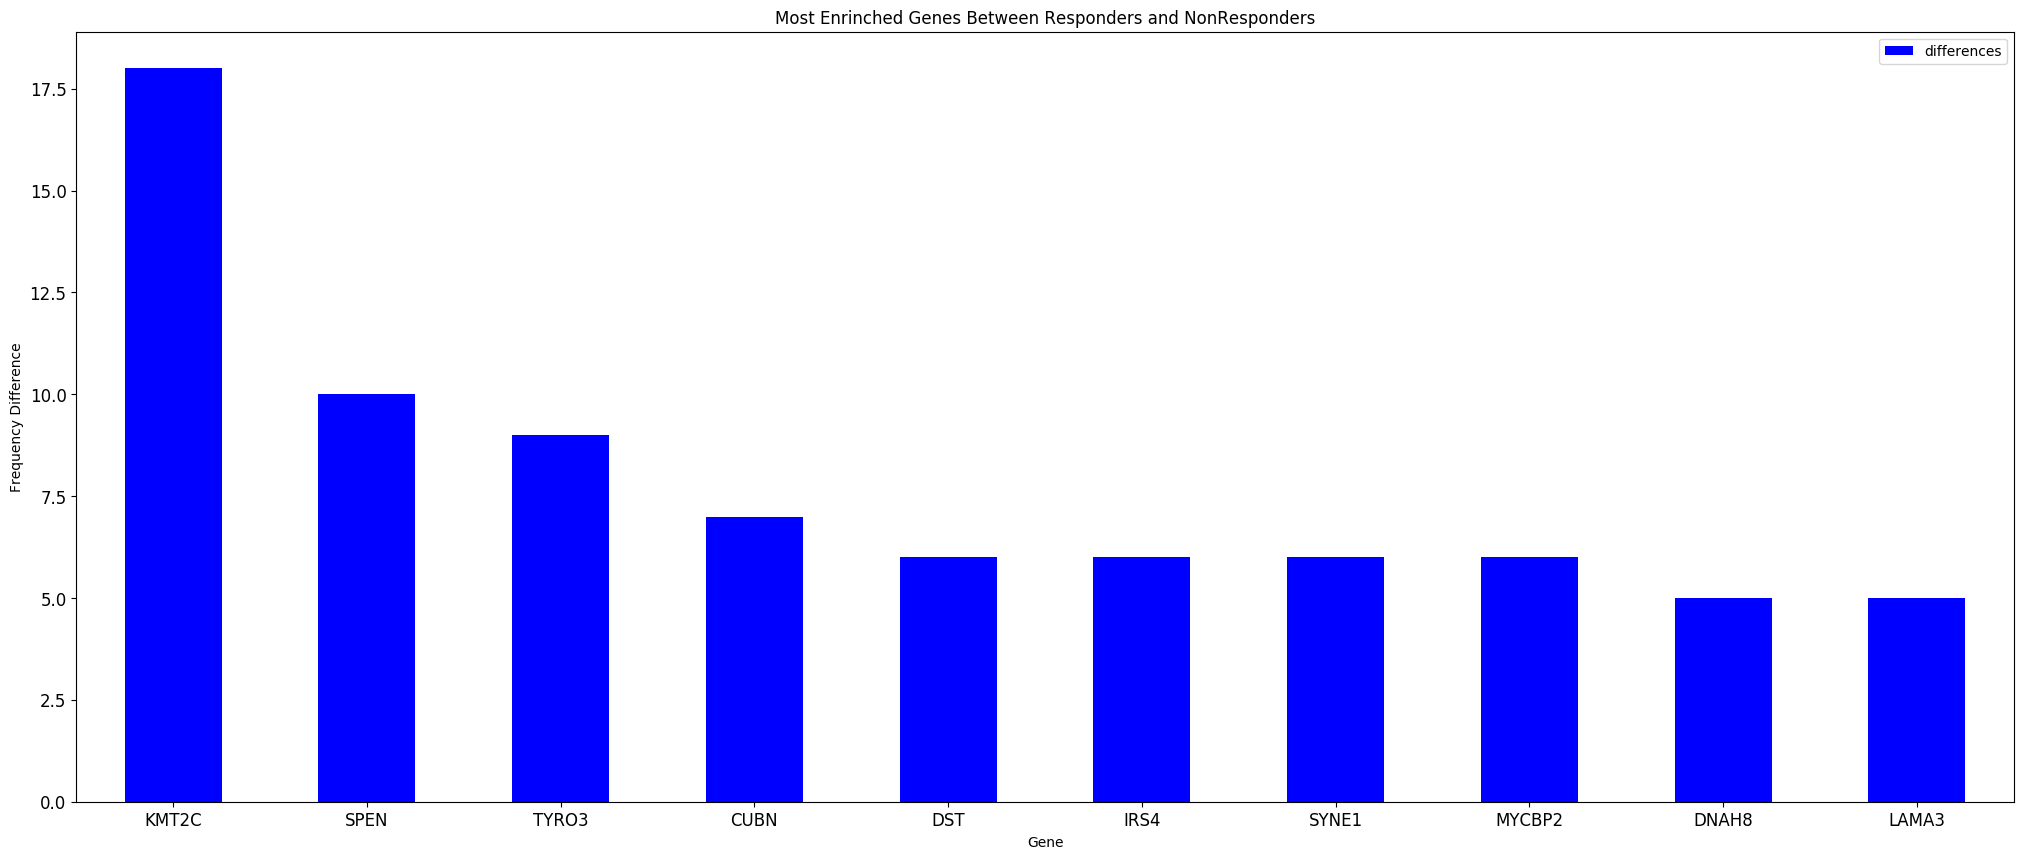

In [ ]:

#Read patiend id info
PatientResponses = pd.read_table('data/sample-information.tsv')
#Get response type
PatientResponses_small = PatientResponses[['Patient_ID', 'Response']].copy()
#Parse patient data by response
responders = []
nonResponders = []
for row in PatientResponses_small.itertuples(index=False):
    if row[1]=='Non-Responder':
        nonResponders.append(patientDf.get(row[0]))
    else:
        responders.append(patientDf.get(row[0])) 

#CHECK COUNT OF EACH ENSURE SAME
print(len(responders))
print(len(nonResponders))



In [ ]:
#Concat databases
respondersDf = pd.concat(responders, ignore_index=True)
nonRespondersDf = pd.concat(nonResponders, ignore_index=True)
responders_count = respondersDf.groupby(
    'Hugo_Symbol').size().reset_index(name='Count')
non_responders_count = nonRespondersDf.groupby(
    'Hugo_Symbol').size().reset_index(name='Count')


# Merge the two DataFrames on 'Hugo_Symbol'
merged_df = pd.merge(responders_count, non_responders_count,
                     on='Hugo_Symbol', suffixes=('_responders', '_non_responders'))

contingency_table = merged_df[[
    'Count_responders', 'Count_non_responders']].to_numpy()

# Perform the Chi-Square test two ensure overall distribution is similar
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square statistic: {chi2}")
print(f"P-value: {p_value}")


In [ ]:
#Calculate differences between response
merged_df['differences'] = merged_df['Count_responders'] - \
    merged_df['Count_non_responders']
merged_df['differences'] = merged_df['differences'].abs()

#Get average to help determine significantly different values
print(merged_df['differences'].mean())
#Sort results
merged_df.sort_values(by=['differences'], ascending=False, inplace=True)

#Top 10 
sigDf = merged_df.head(10)
#Display
sigDf.plot.bar(x='Hugo_Symbol', y='differences', rot=0, figsize=(25, 10), title='Most Enrinched Genes Between Responders and NonResponders',
               fontsize=12, xlabel='Gene', ylabel='Frequency Difference', color='blue')


Explain

Create a scatter plot of genes with the number of mutated patients on the x-axis and
your results from question 4 on the y-axis.

In [ ]:
#Get total counts
sigDf['total'] = sigDf['Count_responders'] + sigDf['Count_non_responders']
#Scatter Plot
sigDf.plot.scatter(x='Hugo_Symbol', y='total', rot=0, figsize=(25, 10), title='Frequency of Enriched Genes',
                   fontsize=12, xlabel='Gene', ylabel='Frequency', color='blue')

#Much more readable version
sigDf.plot.bar(x='Hugo_Symbol', y='total', rot=0, figsize=(25, 10), title='Frequency of Enriched Genes',
               fontsize=12, xlabel='Gene', ylabel='Frequency', color='red')


How many samples are wild-type versus mutant with respect to the most significantly
enriched gene from Question 4? Plot the number of nonsynonymous mutations per
megabase in the mutant vs. wild-type samples. Is there a significant difference in the
number of mutations between the two groups?

KMT2C
227.63000000000002
75.68


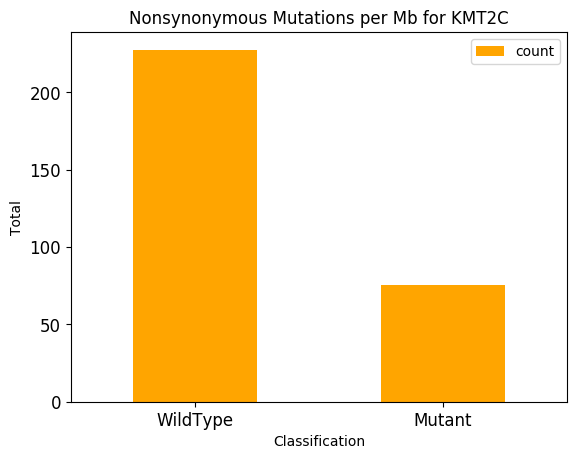

In [ ]:
#Get significant gene
gene = sigDf['Hugo_Symbol'].iloc[0]
print(gene)
#get Nonsynonymous data, parse by patient id
PatientResponses_small = PatientResponses[[
    'Patient_ID', 'Nonsynonymous_mutations_per_Mb']].copy()
NonsynonymousVals = dict(zip(PatientResponses_small.Patient_ID,
                   PatientResponses_small.Nonsynonymous_mutations_per_Mb))
#Get sums and patient ids who have gene
wildtype = []
wildtypeSum = 0
mutantSum = 0
mutant = []
for keys,values in patientDf.items():
    if gene in values['Hugo_Symbol'].values:
        mutant.append(keys)
        mutantSum += NonsynonymousVals.get(keys)
    else:
        wildtype.append(keys)
        wildtypeSum += NonsynonymousVals.get(keys)
    
#Very interesting
print(wildtypeSum)
print(mutantSum)
#Plot results
curDf = pd.DataFrame({'type': ['WildType', 'Mutant'], 'count': [wildtypeSum,mutantSum]})
ax = curDf.plot.bar(x='type', y='count', rot=0, title=f'Nonsynonymous Mutations per Mb for {gene}', ylabel='Total', xlabel='Classification', fontsize=12, color='orange')



Is there a significant difference in the
number of mutations between the two groups?

## Conclusion